# Lexis Date Parser

This script normalizes dates from LexisUni and visualizes attention across outlets over time.

In [4]:
import os
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dateutil.parser import parse

In [5]:
directory = "data/"
files = [f for f in os.listdir(directory) if f.endswith(".XLSX")]
all_data = []

for file in files:
    file_path = os.path.join(directory, file)
    try:
        df = pd.read_excel(file_path, engine='openpyxl')  # Use openpyxl for .xlsx files
        df['Source'] = file
        print(len(df))
        all_data.append(df)
        print(f"Loaded {file} with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error reading {file}: {e}")

combined_df = pd.concat(all_data, ignore_index=True)

410
Loaded AD 2022-2023 hele sample.XLSX with 410 rows and 22 columns
462
Loaded AD 2019-2021 hele sample.XLSX with 462 rows and 22 columns
353
Loaded Volkskrant 2019-2021 hele sample.XLSX with 353 rows and 22 columns
0
Loaded Volkskrant 2022-2024 bijna hele sample.XLSX with 0 rows and 22 columns
396
Loaded Telegraaf 2022-2024 hele sample.XLSX with 396 rows and 22 columns
487
Loaded NRC 2022-2024 hele sample.XLSX with 487 rows and 22 columns
166
Loaded AD 2024 hele sample.XLSX with 166 rows and 22 columns
16
Loaded Volkskrant 2022-2024 einde sample laatste 16.XLSX with 16 rows and 22 columns
217
Loaded Telegraaf 2019-2021 hele sample.XLSX with 217 rows and 22 columns
366
Loaded NRC 2019-2021 hele sample.XLSX with 366 rows and 22 columns


In [6]:
# Function to normalize date format

def normalize_datum(date_str):
   
    month_translation = {
        "januari": "January", "februari": "February", "maart": "March", "april": "April",
        "mei": "May", "juni": "June", "juli": "July", "augustus": "August", "september": "September",
        "oktober": "October", "november": "November", "december": "December"
    }
    
    for dutch, english in month_translation.items():
        date_str = date_str.replace(dutch, english)

    date_str = " ".join(word for word in date_str.split() if not word.isalpha() or word in month_translation.values())
    return parse(date_str, dayfirst=True).date()

combined_df["Datum"] = combined_df["Datum"].apply(normalize_datum)

combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])
print(combined_df["Datum"])

0      2022-01-09
1      2022-01-09
2      2022-01-09
3      2022-01-10
4      2022-01-12
          ...    
2868   2021-12-29
2869   2021-12-31
2870   2021-12-31
2871   2021-12-31
2872   2021-12-31
Name: Datum, Length: 2873, dtype: datetime64[ns]


In [7]:
publication_map = {
    'AD/Algemeen Dagblad.nl': 'Algemeen Dagblad',
    'AD/Algemeen Dagblad': 'Algemeen Dagblad',
    'de Volkskrant': 'Volkskrant',
    'De Volkskrant.nl': 'Volkskrant',
    'De Telegraaf.nl': 'Telegraaf',
    'De Telegraaf': 'Telegraaf',
    'NRC.nl': 'NRC',
    'NRC Handelsblad': 'NRC',
    'NRC': 'NRC'
}

# Normalize the 'Publicatie' column using the mapping
combined_df['Publicatie'] = combined_df['Publicatie'].replace(publication_map)
# Check the unique values after normalization
print(combined_df['Publicatie'].unique())

['Algemeen Dagblad' 'Volkskrant' 'Telegraaf' 'NRC']


## Visualize

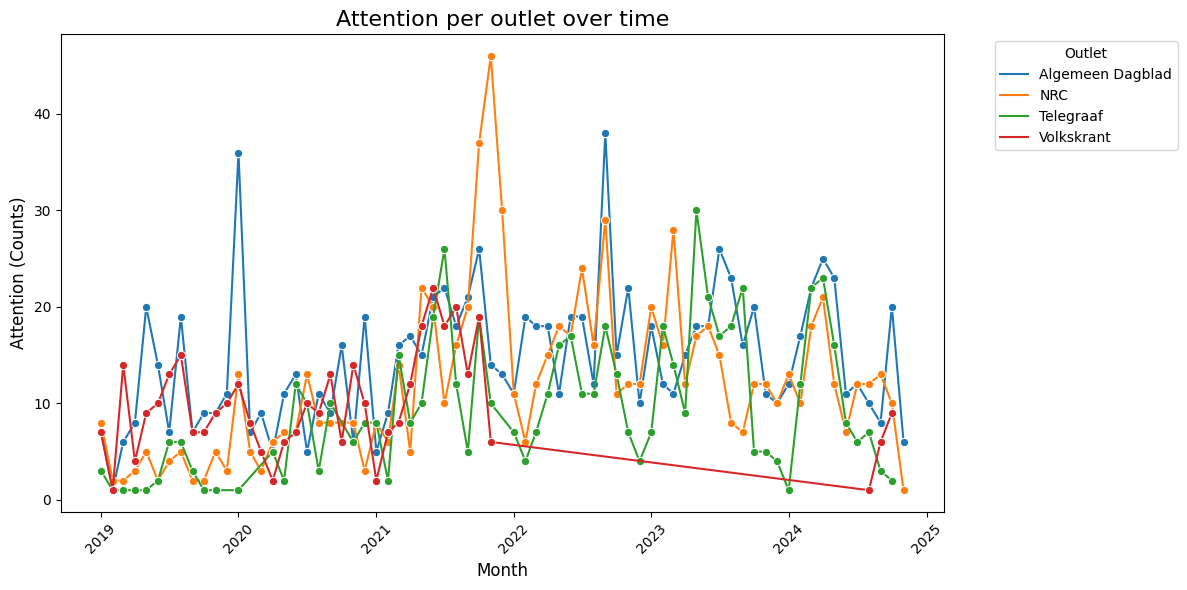

In [10]:

aggregated_df = combined_df.groupby(['Datum', 'Publicatie']).size().reset_index(name='Attention')
aggregated_df['Month'] = aggregated_df['Datum'].dt.to_period('M').dt.to_timestamp()
monthly_df = aggregated_df.groupby(['Month', 'Publicatie'])['Attention'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_df, x='Month', y='Attention', hue='Publicatie', marker='o')

plt.title('Attention per outlet over time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Attention (Counts)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [12]:
combined_df[["Publicatie", "Datum"]].head()

,Publicatie,Datum
0,Algemeen Dagblad,2022-01-09
1,Algemeen Dagblad,2022-01-09
2,Algemeen Dagblad,2022-01-09
3,Algemeen Dagblad,2022-01-10
4,Algemeen Dagblad,2022-01-12


In [17]:
combined_df.to_csv("data/normalized_data/normalized_dates.csv", index=False, encoding="utf-8")
combined_df.to_excel("data/normalized_data/normalized_dates.xlsx", index=False, engine="openpyxl")

## Suggestion for sampling strategy: Constructed month sampling (tbd)


A constructed month sampling strategy is a way to create a representative selection of news coverage from a given month while making sure every publication is fairly represented. Instead of randomly picking days, this method selects one day per week for each publication, ensuring that the sample isn't skewed toward a specific period within the month. Some outlets publish every day, while others might only have articles on certain days, so this approach adjusts for that by only sampling from weeks where an outlet actually published something.

The process starts by grouping the data by both the OUTLET and the MONTH. Within each group, it identifies the weeks where articles were published. Instead of forcing a selection from every week, it only picks from the ones that actually have coverage. From each available week, it randomly selects one day. This means that if a newspaper only published in three out of four weeks in a month, the sample would reflect that naturally without introducing bias.

This method ensures that the sample is not dominated by certain weeks or missing major timeframes/ by specific outlets.





In [14]:

combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])

combined_df["YearMonth"] = combined_df["Datum"].dt.to_period("M")
combined_df["Week"] = combined_df["Datum"].dt.isocalendar().week  # ISO week number


def sample_constructed_month(df):
    sampled_days = []
    
    # Group by month and outlet
    for (year_month, outlet), group in df.groupby(["YearMonth", "Publicatie"]):
        # Get available weeks
        available_weeks = group["Week"].unique()
        
        # Sample one random day per available week
        weekly_samples = (
            group.groupby("Week", group_keys=False)  # Add group_keys=False here
            .apply(lambda x: x.sample(n=1, random_state=42))  # Sample one day per week
            .reset_index(drop=True)
        )
        sampled_days.append(weekly_samples)
    
    return pd.concat(sampled_days, ignore_index=True)



constructed_month_df = sample_constructed_month(combined_df)

constructed_month_df = constructed_month_df.drop(columns=["YearMonth", "Week"])

print(f"Total sampled items: {constructed_month_df.shape[0]}")

Total sampled items: 903


In [15]:
constructed_month_df

,Titel,Datum,Plaats van publicatie,Publicatie,Publicatietype,Lengte,Sectie,Lengte.1,Landen,Auteur,...,Bedrijf,Titel.1,Hlead,Publicatie.1,Publicatietype.1,Pub-copyright,Weergeven,Termen,Ticker,Source
0,Augustus,2019-01-05,International,Algemeen Dagblad,News,1518,"Magazine;Blz. 38, 39, 40, 41",1518,"Netherlands, Kingdom of the",CATHÉRINE VAN DER LINDEN,...,NaN,Augustus,Augustus De maand waarin we aandacht besteden ...,AD/Algemeen Dagblad,Krant,NaN,NaN,NaN,NaN,AD 2019-2021 hele sample.XLSX
1,Universiteit boos op Nashville-professor,2019-01-09,International,Algemeen Dagblad,News,234,Nieuwsdienst;Blz. 9,234,"Netherlands, Kingdom of the",NIELS KLAASSEN,...,NaN,Universiteit boos op Nashville-professor,Universiteit boos op Nashville-professor De Vr...,AD/Algemeen Dagblad,Krant,NaN,NaN,NaN,NaN,AD 2019-2021 hele sample.XLSX
2,Transgenders mogen geweerd,2019-01-23,International,Algemeen Dagblad,News,44,Nieuwsdienst;Blz. 2,44,"Netherlands, Kingdom of the",NaN,...,NaN,Transgenders mogen geweerd,Transgenders mogen geweerd Leger Het Amerikaan...,AD/Algemeen Dagblad,Krant,NaN,NaN,NaN,NaN,AD 2019-2021 hele sample.XLSX
3,"Informatief Hij is een zij NPO 3, 20.25-21.00u.",2019-01-08,International,NRC,News,95,DE GIDS;Blz. 10,95,"Netherlands, Kingdom of the",NaN,...,NaN,"Informatief Hij is een zij NPO 3, 20.25-21.00u.","Informatief Hij is een zij NPO 3, 20.25-21.00u...",NRC Handelsblad,Krant,NaN,NaN,NaN,NaN,NRC 2019-2021 hele sample.XLSX
4,Homo is nog steeds het meest gebruikte scheldw...,2019-01-26,International,NRC,News,1547,WEEKEND;Blz. 30,1547,"Netherlands, Kingdom of the",Danielle Pinedo foto Merlijn Doomernik,...,NaN,Homo is nog steeds het meest gebruikte scheldw...,Homo is nog steeds het meest gebruikte scheldw...,NRC.NEXT,Krant,NaN,NaN,NaN,NaN,NRC 2019-2021 hele sample.XLSX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,Voor 'Emilia Pérez' leunde Audiard op de leven...,2024-10-16,International,Volkskrant,News,1461,NaN,1461,"Netherlands, Kingdom of the",Bor Beekman,...,NaN,Voor 'Emilia Pérez' leunde Audiard op de leven...,Voor 'Emilia Pérez' leunde Audiard op de leven...,De Volkskrant.nl,Web Publicatie,NaN,NaN,NaN,NaN,Volkskrant 2022-2024 einde sample laatste 16.XLSX
899,The Space Choir: dit is waarom het popkoor van...,2024-11-03,International,Algemeen Dagblad,News,604,NaN,604,"Netherlands, Kingdom of the",Esmee Peper,...,NaN,The Space Choir: dit is waarom het popkoor van...,The Space Choir: dit is waarom het popkoor van...,AD/Algemeen Dagblad.nl,Web Publicatie,NaN,NaN,NaN,NaN,AD 2024 hele sample.XLSX
900,Michael van Gerwen treft debuterende trans vro...,2024-11-04,International,Algemeen Dagblad,News,469,NaN,469,"Netherlands, Kingdom of the",Tim Hartman,...,NaN,Michael van Gerwen treft debuterende trans vro...,Michael van Gerwen treft debuterende trans vro...,AD/Algemeen Dagblad.nl,Web Publicatie,NaN,NaN,NaN,NaN,AD 2024 hele sample.XLSX
901,"Dit is Jip (27) uit Breda, geen hij of zij maa...",2024-11-15,International,Algemeen Dagblad,News,581,NaN,581,"Netherlands, Kingdom of the",Kaylee Noteboom,...,NaN,"Dit is Jip (27) uit Breda, geen hij of zij maa...","Dit is Jip (27) uit Breda, geen hij of zij maa...",AD/Algemeen Dagblad.nl,Web Publicatie,NaN,NaN,NaN,NaN,AD 2024 hele sample.XLSX
